## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하였습니다.

* sunnysai12345/News_Summary

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data.loc[1,'headlines'] #요약길이 정도를 알고싶어 하나만 가져와서 확인

'Delhi techie wins free food from Swiggy for one year on CRED'

In [3]:
data.sample(10) # 10개의 랜덤셈플 확인

,headlines,text
20029,"Saina, Sindhu reach Asiad semis to assure Indi...",Indian shuttlers Saina Nehwal and PV Sindhu ha...
60506,Pacific coasts may lose up to 80% fish due to ...,A Canada-based study predicts that Pacific Isl...
58266,"Sexy added to 'S Durga' title for publicity, s...",Acting Chairman of the International Film Fest...
95817,Bank of Maharashtra loses Ã¢ÂÂ¹25 crore due t...,In one of the biggest Unified Payments Interfa...
39576,Shahid Afridi has been 36 for about 7 years: S...,"Shane Watson, in Harbhajan Singh's chat show, ..."
17348,Forex reserves fall below $400 billion for fir...,India's foreign exchange reserves fell below $...
61707,Iran complying with 2015 nuclear deal: UN watc...,Iran is complying with the 2015 nuclear deal i...
28765,Shashi honoured for contribution to Indian cin...,The International Indian Film Academy (IIFA) A...
32180,SRH defeat RCB by 5 runs to register 5th strai...,SunRisers Hyderabad defeated Royal Challengers...
48162,Cabinet clears direct admission to PhD in IITs...,The Union Cabinet has cleared the proposal all...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.  
추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (1) 데이터 정리하기 (추상적 요약) 

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요

### 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum()) #null값들을 합산해서 보여준다.

headlines    0
text         0
dtype: int64


NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리에요. 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있어요. 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정이에요.

### 2.2 텍스트 정규화와 불용어 제거

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines  = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines , False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [11]:
clean_text = []
# 전체 text 데어터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
print("text 전처리 후 결과 : ", clean_text[:5])

text 전처리 후 결과 :  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insu

결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었죠. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고,  headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

In [12]:
clean_headlines = []
# 전체  headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print(" headlines 전처리 후 결과: ", clean_headlines[:5])

 headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [13]:
# 데이터들을 데이터프레임에 저장, empty 값이 있으면 Null 값으로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


.isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
# null값이 생겼을시 제거 함수
'''data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))'''

"data.dropna(axis=0, inplace=True)\nprint('전체 샘플수 :', (len(data)))"

### 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.
문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 것입니다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines 남아 있는 게 더 좋을 것 같습니다. 추가로 영문과 한국어를 비교했을경우 한국어의 경우 조사나 접속사 등의 사용이 영문에 비해 다양하여 의미가 많이 달라질 것 같으므로 한국어는 데이터를 분석해서 직접 불용어를 지정해서 제거해 주는 것이 좋을 거 같습니다.

## 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

### 2.3 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


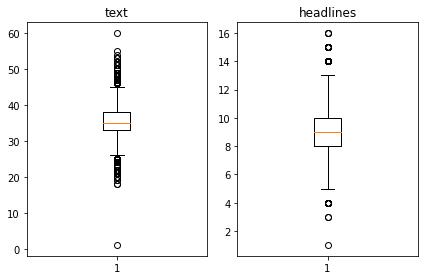

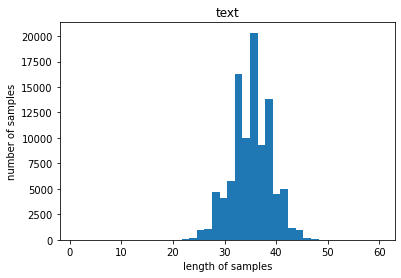

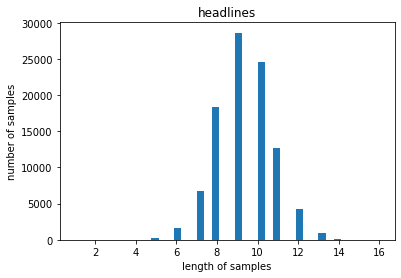

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이가 그렇게 크지않다. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 40 내외의 길이를 가진다는 것을 확인할 수 있어요.

headlines 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 짧아요. 그래프로 봤을 때에도 대체적으로 12이하의 길이를 가지고 있네요.

이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.

In [18]:
# text 최대 길이랑 headlines 최대 길이 임의지정
text_max_len = 40
headlines_max_len = 10
print('=3')

=3


각각 40과 10으로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


이렇게 만든 함수를 text와 headlines 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.



In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


각각 40과 10으로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, text 열의 경우에는 약 8%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### 2.4 시작 토큰과 종료 토큰 추가하기

앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 headlines 열로부터 만들 거예요.

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[45740 62806 44650 ... 55890 15630 20168]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


훈련 데이터와 테스트 데이터가 각각 59,282개와 14,820개로 잘 분리된 것을 볼 수 있어요!

## 데이터 전처리하기 (3) 정수 인코딩

### 2.5 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.



In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61540
등장 빈도가 6번 이하인 희귀 단어의 수: 42229
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19311
단어 집합에서 희귀 단어의 비율: 68.62040948976275
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.201060256202557


encoder_input_train에는 6만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 68% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.2%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[7532, 377, 1, 1205, 368, 57, 5323, 446, 142, 5203, 4820, 2428, 200, 13, 4, 377, 1, 57, 362, 1811, 2428, 3105, 200, 642, 705], [36, 25, 79, 1669, 1936, 393, 245, 1160, 157, 803, 368, 1, 333, 2293, 4, 1861, 9, 2979, 468, 1774, 293, 1160, 6, 155, 13, 543], [3887, 3309, 642, 3717, 2694, 2271, 1409, 3866, 3106, 2784, 242, 3218, 3737, 2694, 149, 3034, 3718, 1294, 4516, 3866, 1294, 192, 85, 1546, 6, 7533, 620, 5968, 3129, 1, 219]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

headlines 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.



In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27319
등장 빈도가 5번 이하인 희귀 단어의 수: 18241
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9078
단어 집합에서 희귀 단어의 비율: 66.77037958929682
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.963923975674688


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 66%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.96%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.



In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 200, 57, 696, 634, 345], [1, 723, 84, 640, 32, 369, 293, 8, 490, 941, 29], [1, 1574, 1884, 1043, 90, 616, 6, 308], [1, 402, 387, 6, 1651, 786, 7, 1602], [1, 19, 549, 213, 3, 454, 501]]
target
decoder  [[200, 57, 696, 634, 345, 2], [723, 84, 640, 32, 369, 293, 8, 490, 941, 29, 2], [1574, 1884, 1043, 90, 616, 6, 308, 2], [402, 387, 6, 1651, 786, 7, 1602, 2], [19, 549, 213, 3, 454, 501, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 요약문(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 59272
훈련 레이블의 개수 : 59272
테스트 데이터의 개수 : 14818
테스트 레이블의 개수 : 14818


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있어요. 이제 거의 다 왔어요.

### 2.6 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.  
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 3.1 모델 설계하기

In [41]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터 차원 128
hidden_size = 256   # hidden state는 용량의 크기, LSTM에서의 뉴련의 개수

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용해요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

어텐션 메커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

### 3.2 모델 훈련하기

In [42]:
# 설계한 모델로 훈련 진행하기

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 특정 조건이 충족되면 훈련을 멈추는 역할
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
116/116 [==============================] - 79s 552ms/step - loss: 4.5984 - val_loss: 4.3094
Epoch 2/50
116/116 [==============================] - 62s 533ms/step - loss: 4.1976 - val_loss: 4.0636
Epoch 3/50
116/116 [==============================] - 61s 529ms/step - loss: 3.9618 - val_loss: 3.8419
Epoch 4/50
116/116 [==============================] - 62s 536ms/step - loss: 3.7490 - val_loss: 3.6528
Epoch 5/50
116/116 [==============================] - 61s 526ms/step - loss: 3.5816 - val_loss: 3.5293
Epoch 6/50
116/116 [==============================] - 61s 527ms/step - loss: 3.4456 - val_loss: 3.4286
Epoch 7/50
116/116 [==============================] - 61s 525ms/step - loss: 3.3285 - val_loss: 3.3316
Epoch 8/50
116/116 [==============================] - 61s 524ms/step - loss: 3.2280 - val_loss: 3.2518
Epoch 9/50
116/116 [==============================] - 61s 526ms/step - loss: 3.1390 - val_loss: 3.1944
Epoch 10/50
116/116 [==============================] - 61s 524ms/step - l

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

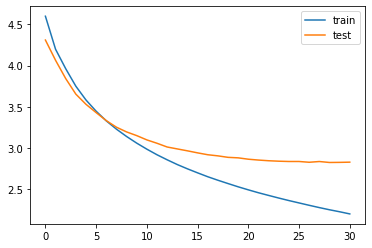

In [43]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3.3 인퍼런스 모델 구현

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### 4.1모델 테스트하기

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [60]:
# 테스트 데이터 약 50개의 샘플에 대해 실제 요약과 예측된 요약 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : secretary iran supreme national security council ali friday said us seeking tear nuclear deal country demanding military site adding iran undisclosed nuclear activity location said issues raised us media 
실제 요약 : us seeking to nuclear deal iran 
예측 요약 :  iran supreme court to ban on iran


원문 : pakistani pacer mohammad amir revealed question answer session twitter according indian captain virat kohli currently world best batsman rating steve smith kane williamson joe root year old served ban spot fixing also revealed enjoyed dismissing sachin tendulkar virat kohli 
실제 요약 : calls virat kohli the world best batsman 
예측 요약 :  kohli kohli to kohli as captain


원문 : former google software engineer james fired week writing anti diversity memo posed photographs outside technology giant headquarters california held sign said fired truth wore shirt logo google read reference forced labour camps soviet union 
실제 요약 : fired engineer for photos outside google 
예측 요약 :  google employee fired f

## Step 5. Summa을 이용해서 추출적 요약해보기
* 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 
* 반대로 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요.

In [61]:
import requests
from summa.summarizer import summarize

In [86]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text = data['text']
print(text[:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1495    India head coach Ravi Shastri has said that he...
1496    Italian tennis player Andreas Seppi ensured hi...
1497    World number three Roger Federer was stopped b...
1498    A cutout of TMC chief and West Bengal CM Mamat...
1499    A Delhi court on Saturday pulled up Delhi Poli...
Name: text, Length: 1500, dtype: object


In [82]:
text[10]

"Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture."

summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [83]:
for _ in range(5):
    random_n = np.random.randint(len(text))
    print("\ntext : {}\n".format(text[random_n]))
    print("\nheadlines : {}\n".format(summarize(text[random_n], ratio=0.5)))
    print("--------------------------------------------------------------")


text : Ranveer Singh took to Instagram to share a video in which he can be seen recreating dance steps of the song 'Sarkai Lo Khatiya' from the 1994 film 'Raja Babu' with Karisma Kapoor. Ranveer captioned the video, "Serendipity! Courtesy Raja Babu!...posted a random video from set today, and who I do meet at the airport two hours later!" 


headlines : Ranveer Singh took to Instagram to share a video in which he can be seen recreating dance steps of the song 'Sarkai Lo Khatiya' from the 1994 film 'Raja Babu' with Karisma Kapoor.

--------------------------------------------------------------

text : US President Donald Trump on Wednesday slammed pornstar Stormy Daniels over the sketch of a man who she claimed threatened her to hide her alleged affair with Trump, calling it "a total con job". "A sketch years later about a nonexistent man...playing the Fake News Media for Fools," he said. The pornstar's lawyer offered a $131,000-reward to identify the man.


headlines : US President Do

# 회고

* Summa추출적 요약기법을 통해 매우 간단하게 요약되어 문장의 표현력이 조금 부족할 지라도 매잘못된 요약이 나올 가능성도 낮고 편하여 훨씬 괜찮은거 같았습니다.

* 성능개선 포인트로 RNN대신 LSTM 활용하여 입력 문장의 순서를 뒤집으면 더욱 높은 정확도를 보인다고 합니다.

reference: https://www.youtube.com/watch?v=4DzKM0vgG1Y

## 추상적 요약 흐름 간단정리

* seq2seq를 사용합니다.
* RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
* 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
* seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
* seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
* 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.